In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from scipy import stats
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import warnings
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
import joblib

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the cleaned dataset
df = pd.read_csv("Network_anomaly_data.csv")

# Check the first few rows of the data
print(df.head())

# Get general information about the dataset
print(df.info())

   duration protocoltype   service flag  srcbytes  dstbytes  land  \
0         0          tcp  ftp_data   SF       491         0     0   
1         0          udp     other   SF       146         0     0   
2         0          tcp   private   S0         0         0     0   
3         0          tcp      http   SF       232      8153     0   
4         0          tcp      http   SF       199       420     0   

   wrongfragment  urgent  hot  ...  dsthostsamesrvrate  dsthostdiffsrvrate  \
0              0       0    0  ...                0.17                0.03   
1              0       0    0  ...                0.00                0.60   
2              0       0    0  ...                0.10                0.05   
3              0       0    0  ...                1.00                0.00   
4              0       0    0  ...                1.00                0.00   

   dsthostsamesrcportrate  dsthostsrvdiffhostrate  dsthostserrorrate  \
0                    0.17                   

In [4]:
# Display missing values before handling
print("Missing values before handling:")
print(df.isnull().sum())

Missing values before handling:
duration                  0
protocoltype              0
service                   0
flag                      0
srcbytes                  0
dstbytes                  0
land                      0
wrongfragment             0
urgent                    0
hot                       0
numfailedlogins           0
loggedin                  0
numcompromised            0
rootshell                 0
suattempted               0
numroot                   0
numfilecreations          0
numshells                 0
numaccessfiles            0
numoutboundcmds           0
ishostlogin               0
isguestlogin              0
count                     0
srvcount                  0
serrorrate                0
srvserrorrate             0
rerrorrate                0
srvrerrorrate             0
samesrvrate               0
diffsrvrate               0
srvdiffhostrate           0
dsthostcount              0
dsthostsrvcount           0
dsthostsamesrvrate        0
dsthostdiffsrvra

# Handle Missing Values:

Numerical Columns: Replace missing values with the median.

Categorical Columns: Replace missing values with the most frequent value.

In [5]:
# Separate numerical and categorical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Replace missing values in numerical columns with the median
for col in numerical_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Replace missing values in categorical columns with the most frequent value
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [6]:
# Display missing values after handling
print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values after handling:
duration                  0
protocoltype              0
service                   0
flag                      0
srcbytes                  0
dstbytes                  0
land                      0
wrongfragment             0
urgent                    0
hot                       0
numfailedlogins           0
loggedin                  0
numcompromised            0
rootshell                 0
suattempted               0
numroot                   0
numfilecreations          0
numshells                 0
numaccessfiles            0
numoutboundcmds           0
ishostlogin               0
isguestlogin              0
count                     0
srvcount                  0
serrorrate                0
srvserrorrate             0
rerrorrate                0
srvrerrorrate             0
samesrvrate               0
diffsrvrate               0
srvdiffhostrate           0
dsthostcount              0
dsthostsrvcount           0
dsthostsamesrvrate        0
dsthostdiffsrvra

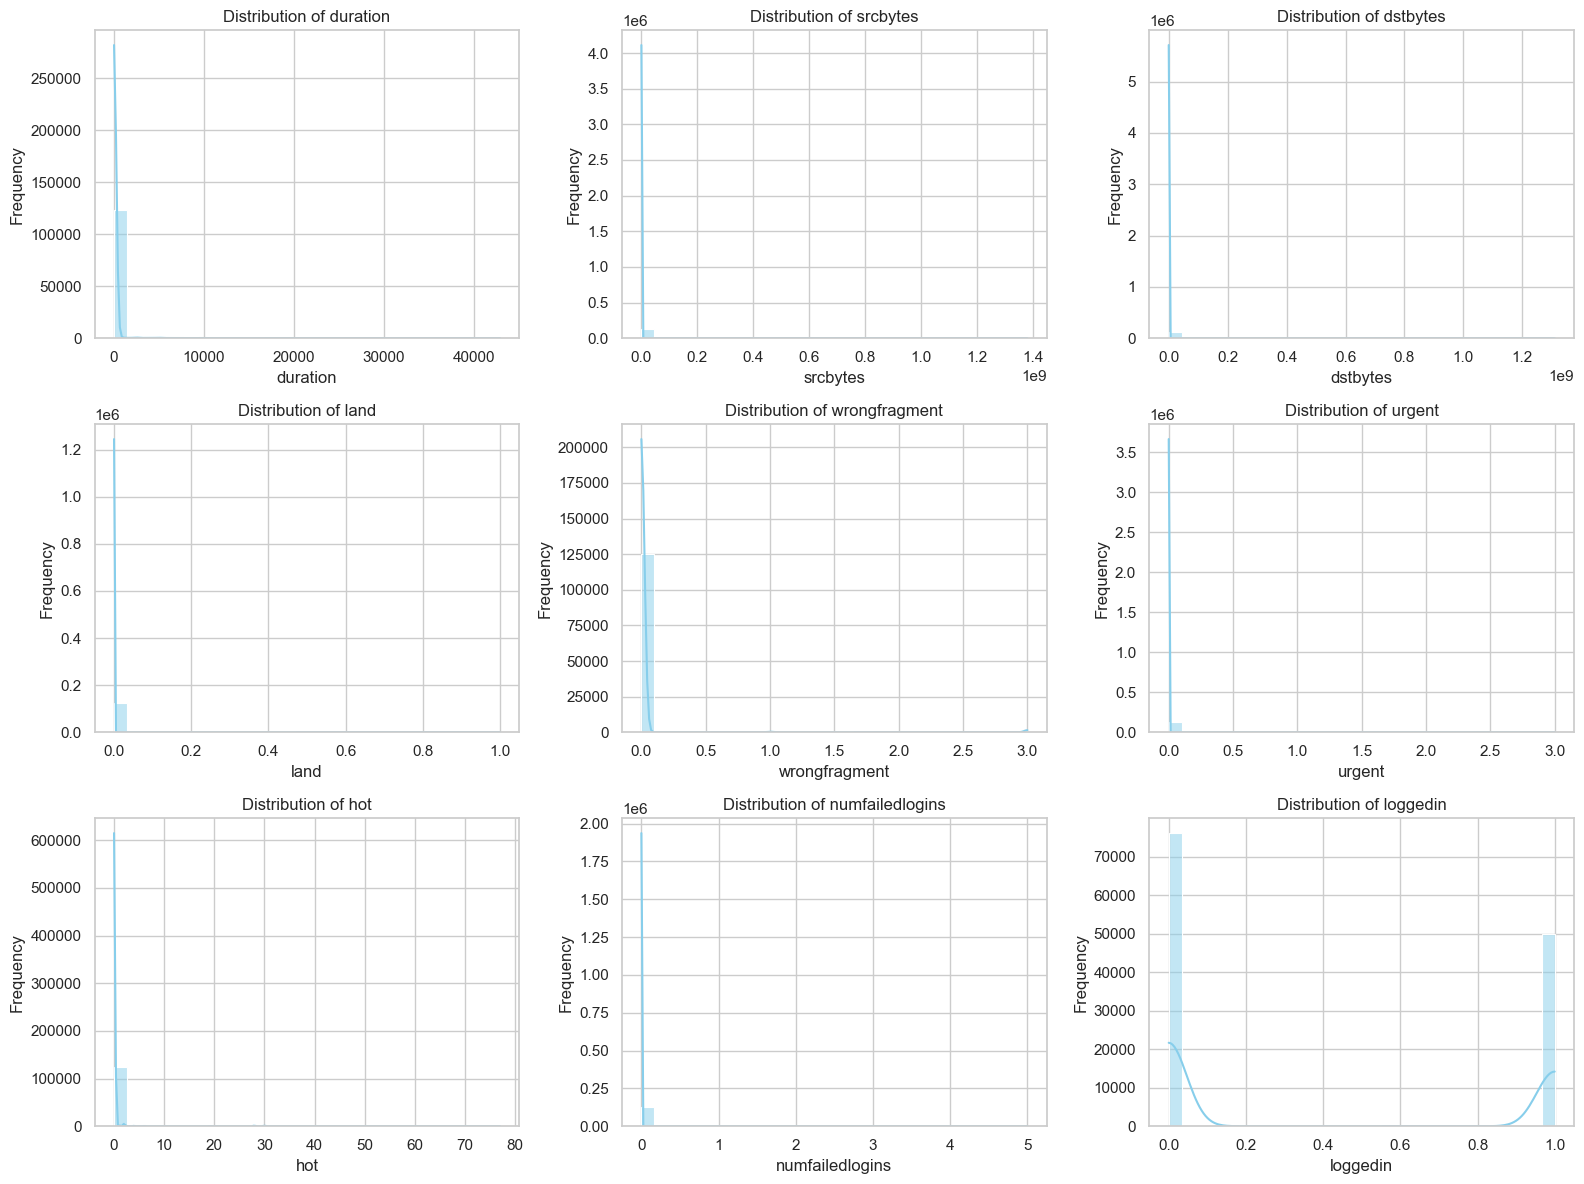

In [7]:
# Set plot style
sns.set(style="whitegrid")

# Function to plot the distribution of numeric features
def plot_feature_distributions(data, feature_columns):
    n_cols = 3
    n_rows = (len(feature_columns) + n_cols - 1) // n_cols
    plt.figure(figsize=(16, n_rows * 4))
    
    for i, feature in enumerate(feature_columns, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(data[feature], kde=True, bins=30, color="skyblue")
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

# Select numeric columns for distribution analysis
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
plot_feature_distributions(df, numeric_columns[:9])  # Plot for the first 9 features initially


## Observations:

Features like duration, srcbytes, and dstbytes have highly skewed distributions, likely influenced by extreme outliers or infrequent high values.
Binary features such as land and urgent show a discrete distribution.
Some features, like wrongfragment, have a significant number of zero entries, indicating sparsity.


In [8]:
def plot_distributions(data):
    # Separate numeric and categorical columns
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns

    # Plot distributions for numeric features
    for column in numeric_columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(data[column], kde=True, bins=30, color="skyblue")
        plt.title(f"Distribution of Numeric Feature: {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

    # Plot distributions for categorical features
    for column in categorical_columns:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=data, x=column, palette="viridis")
        plt.title(f"Distribution of Categorical Feature: {column}")
        plt.xlabel(column)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()



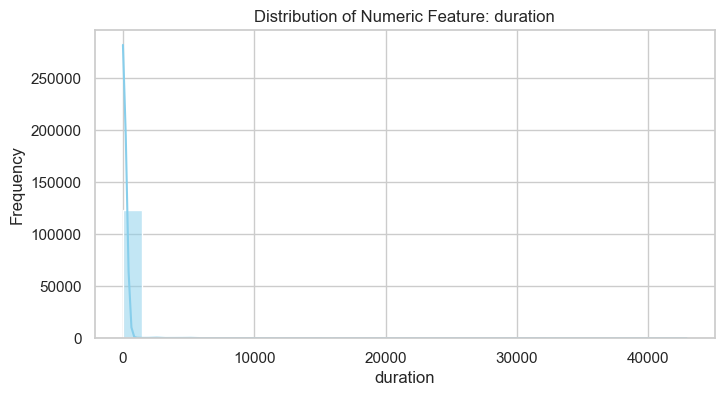

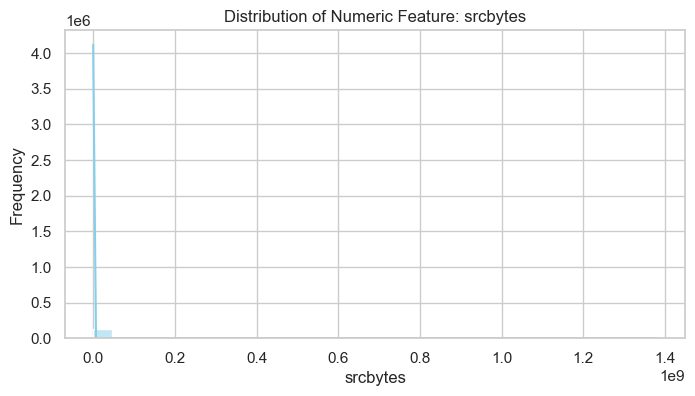

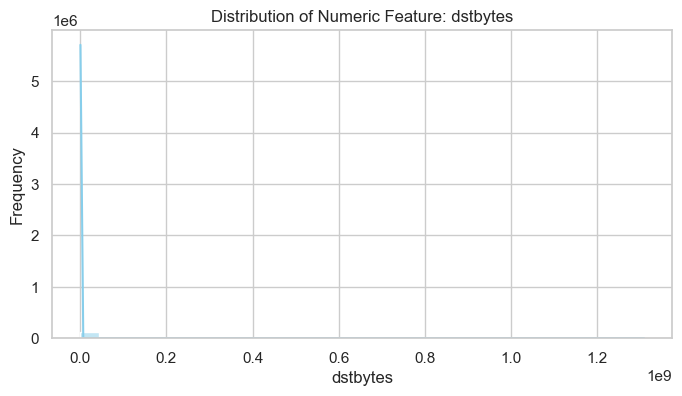

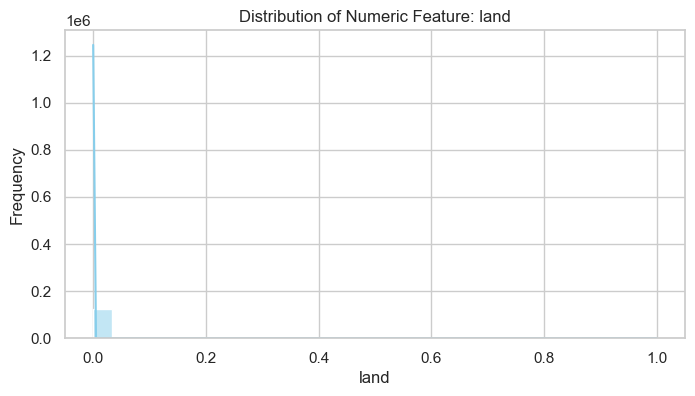

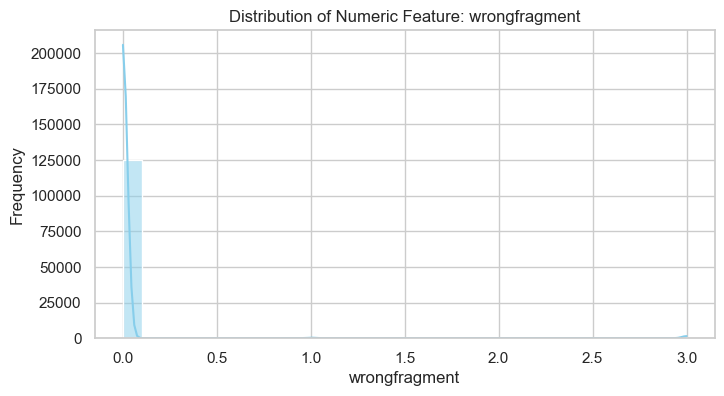

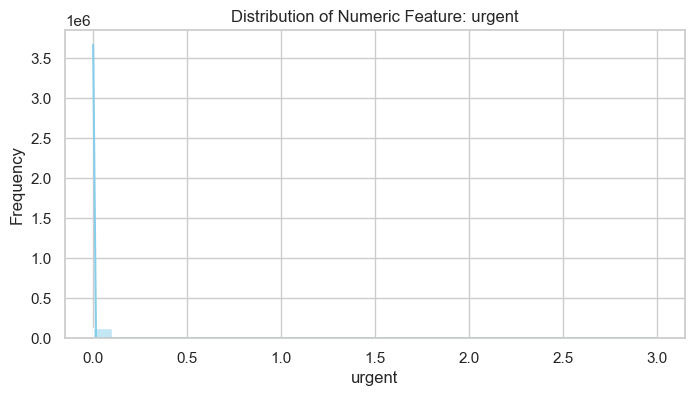

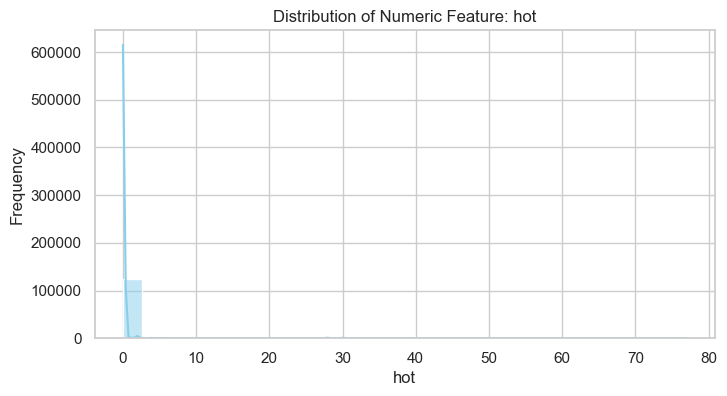

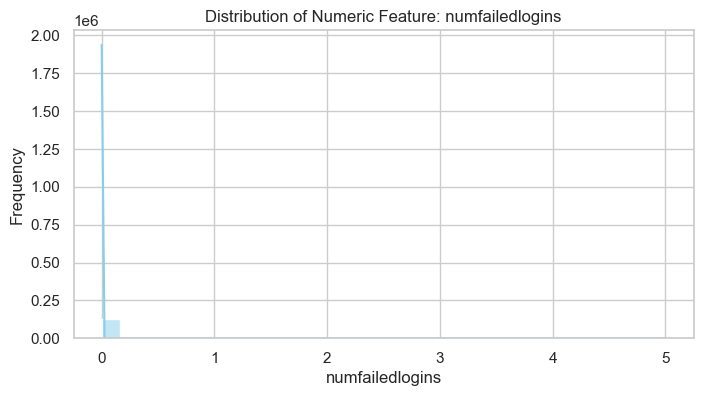

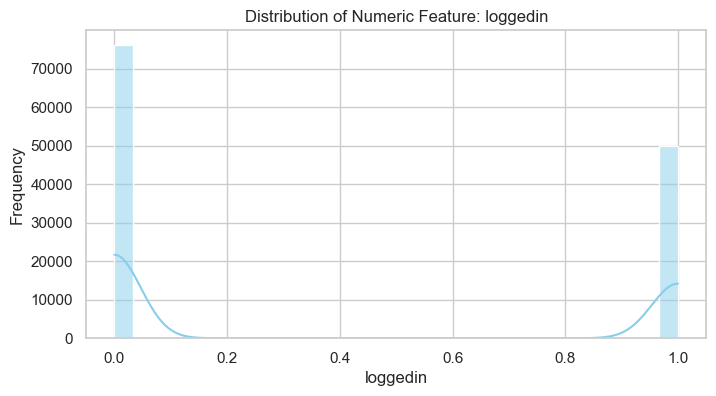

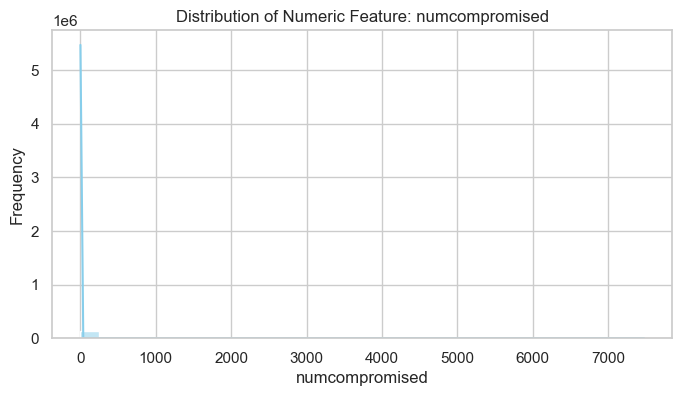

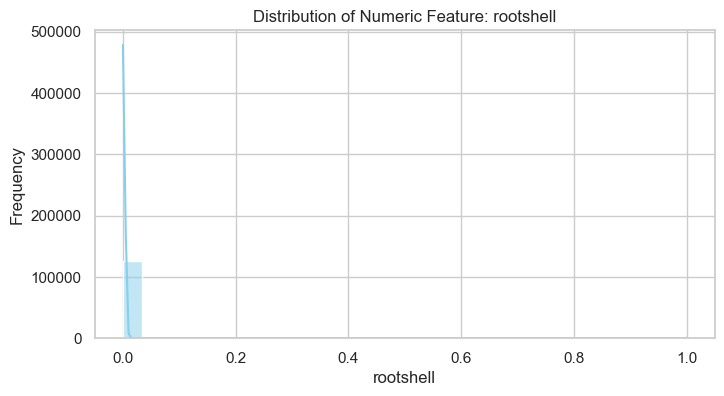

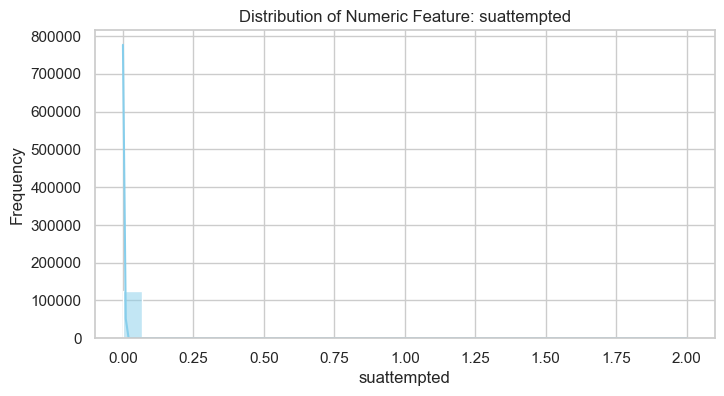

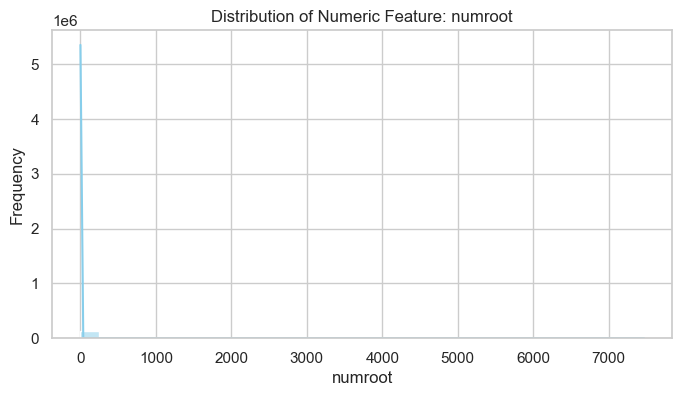

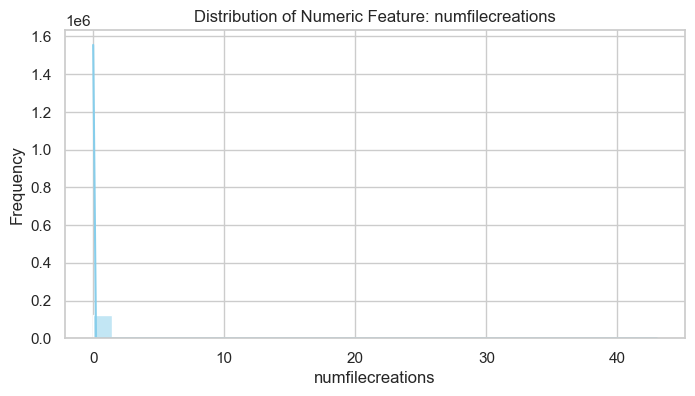

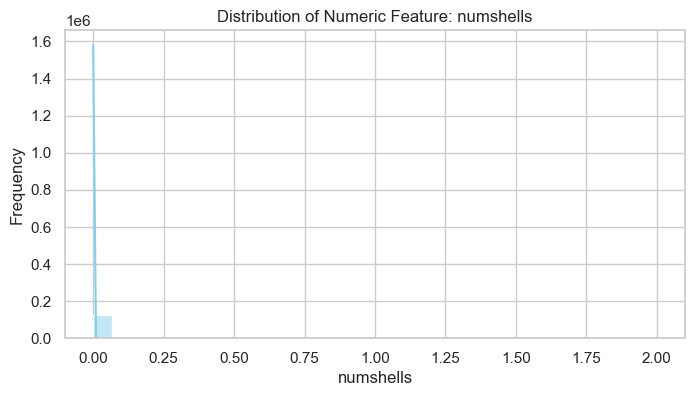

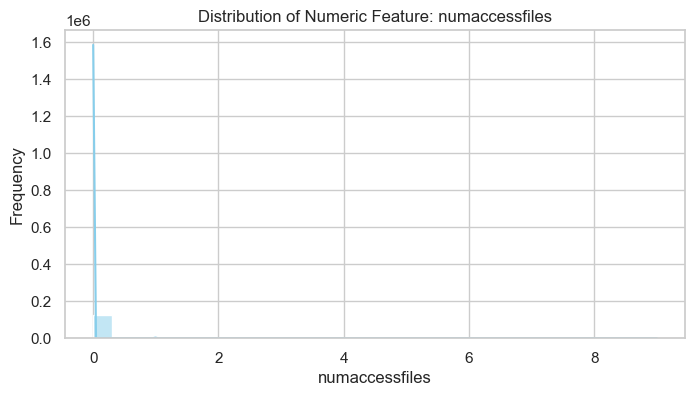

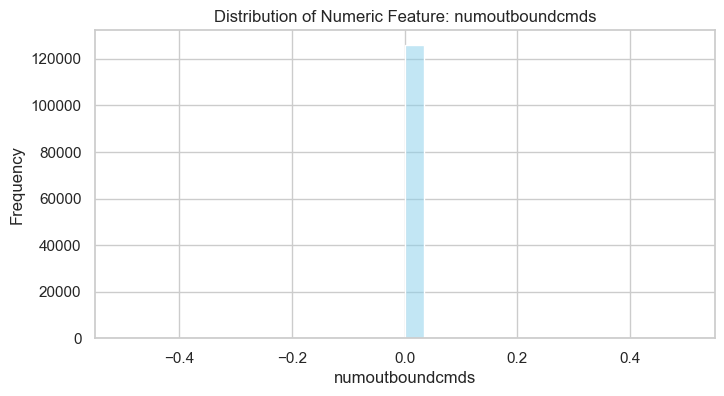

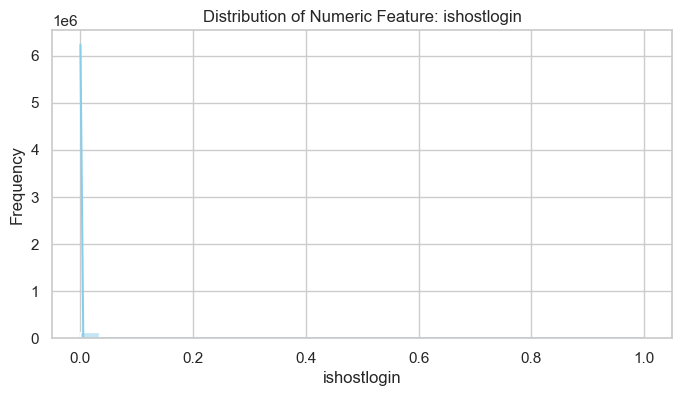

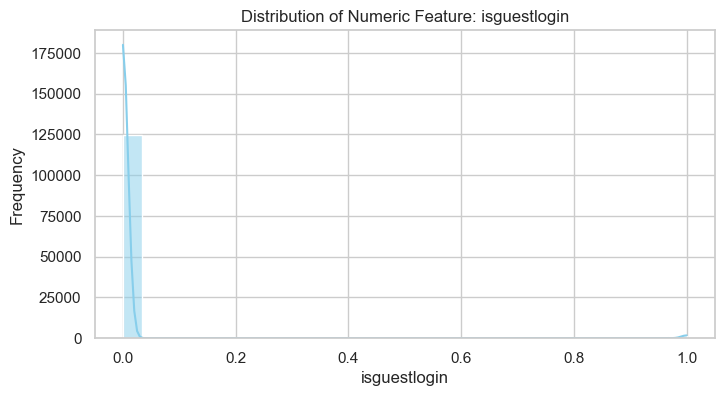

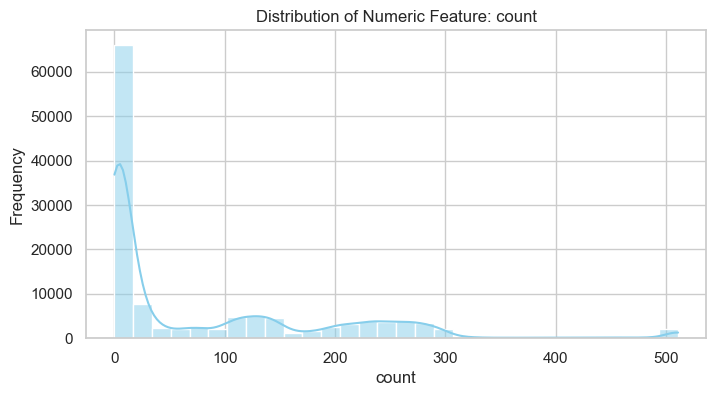

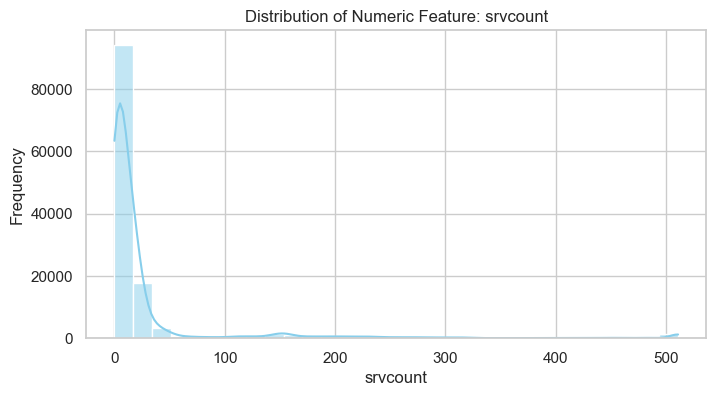

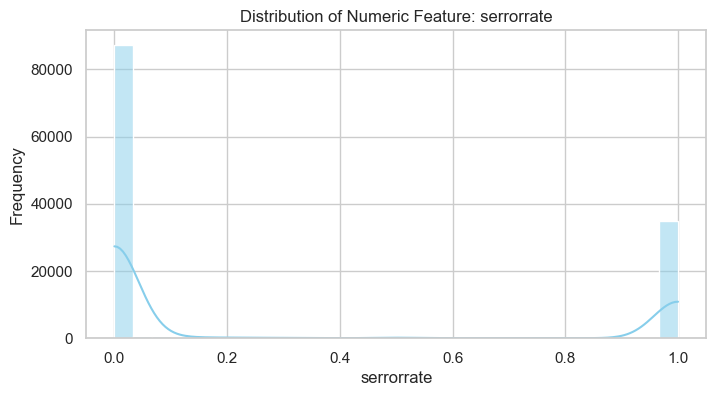

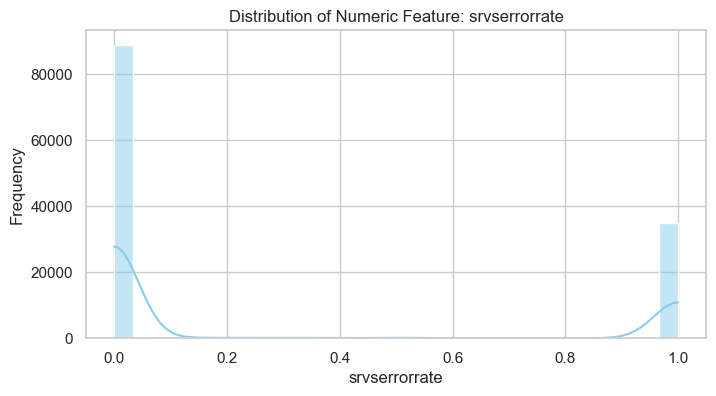

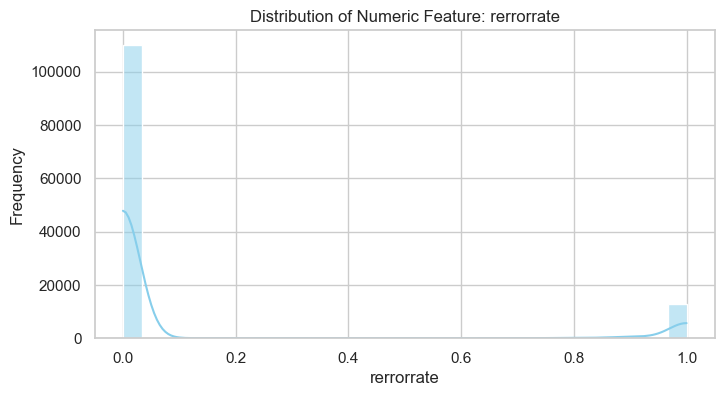

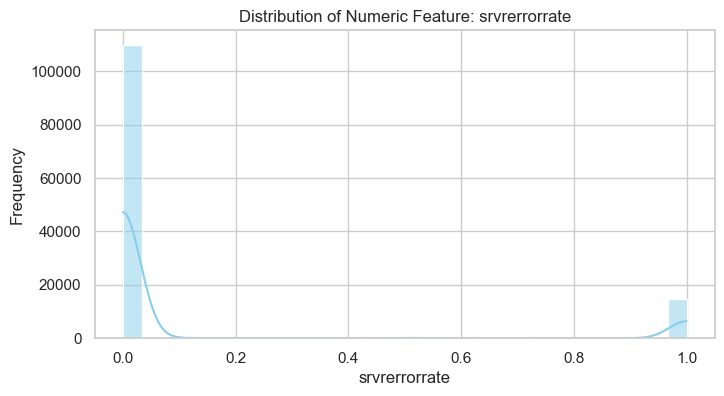

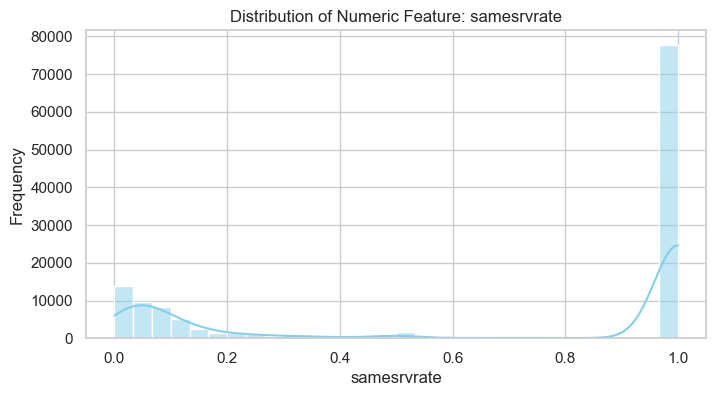

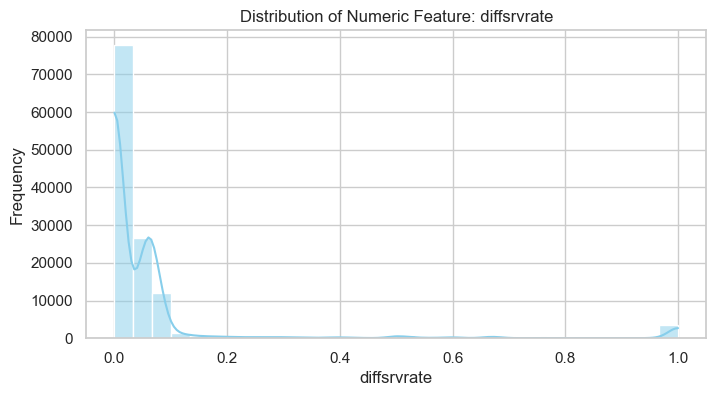

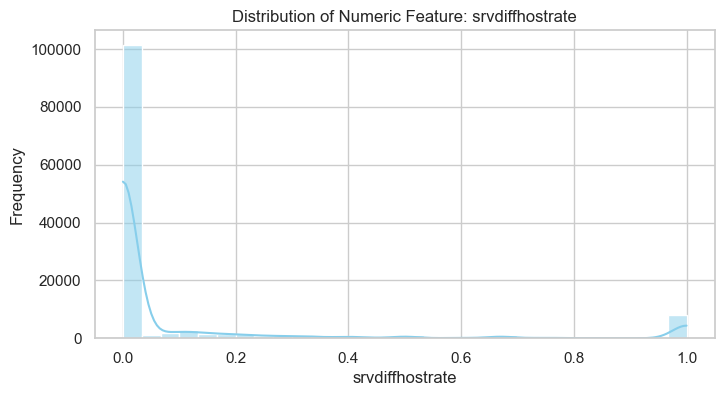

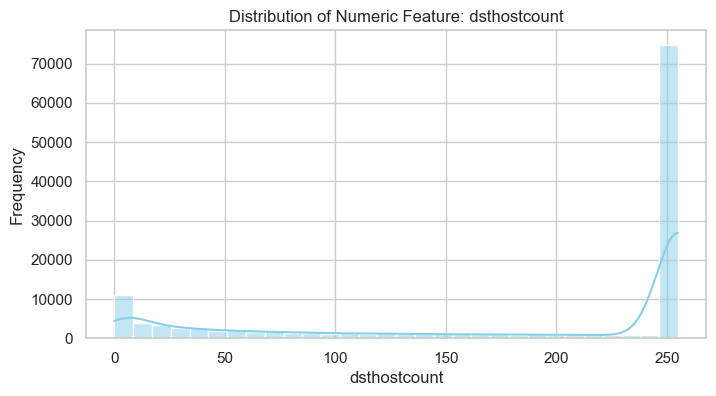

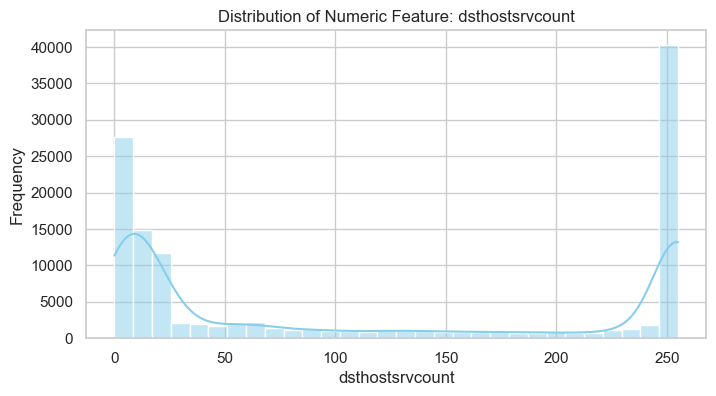

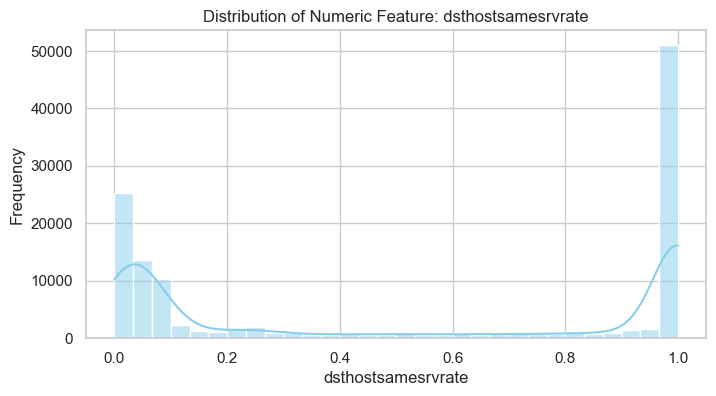

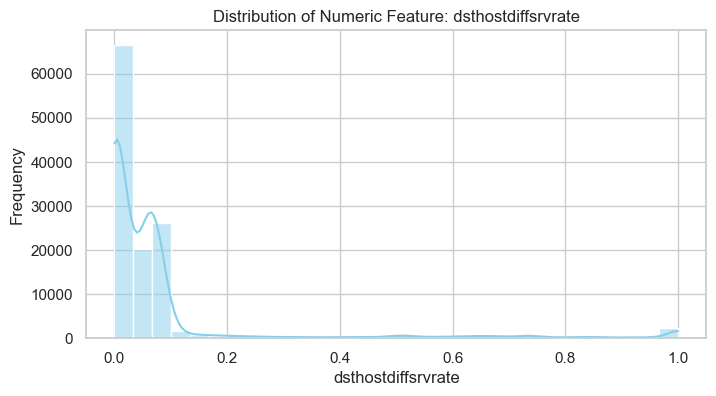

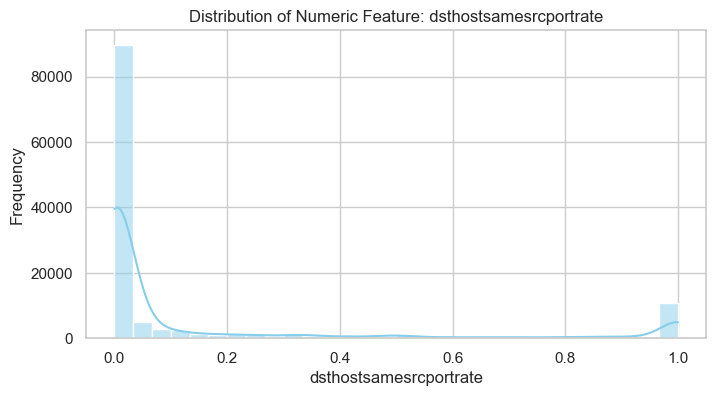

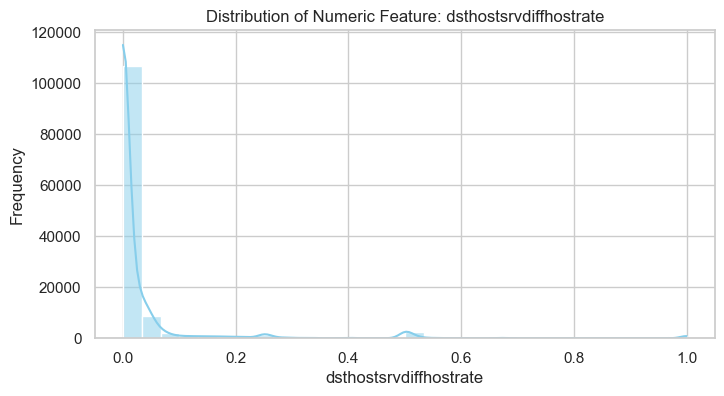

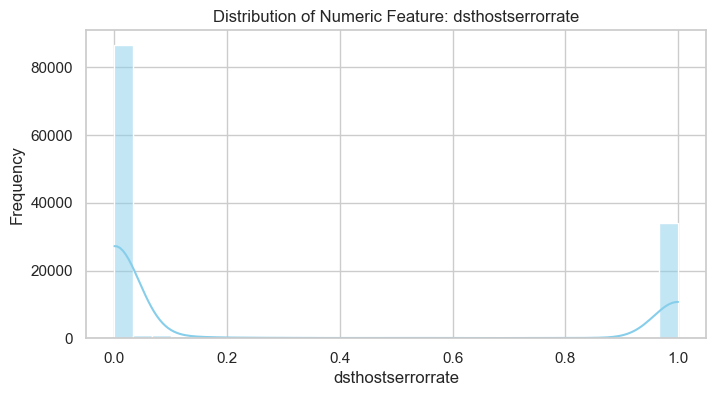

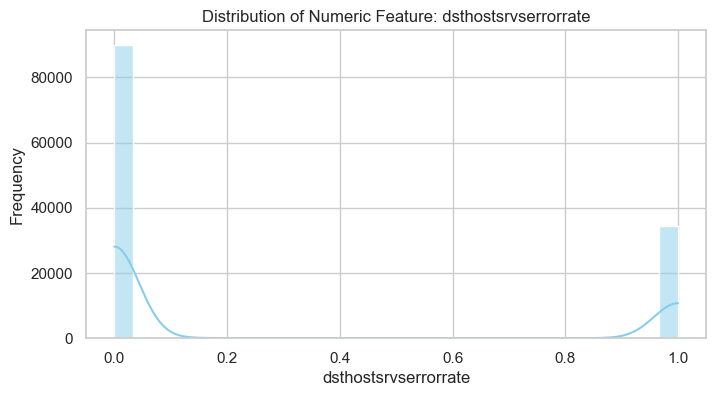

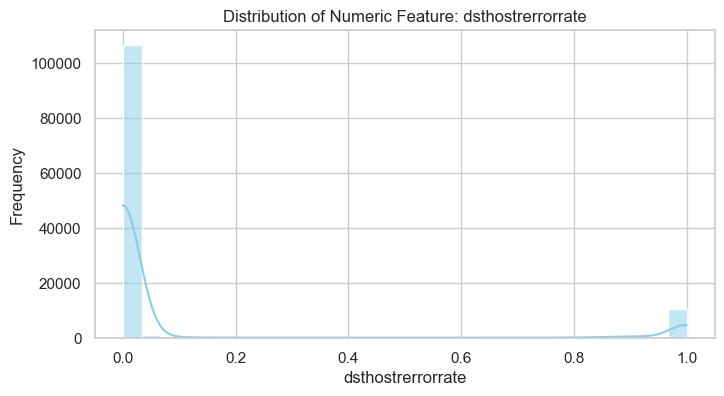

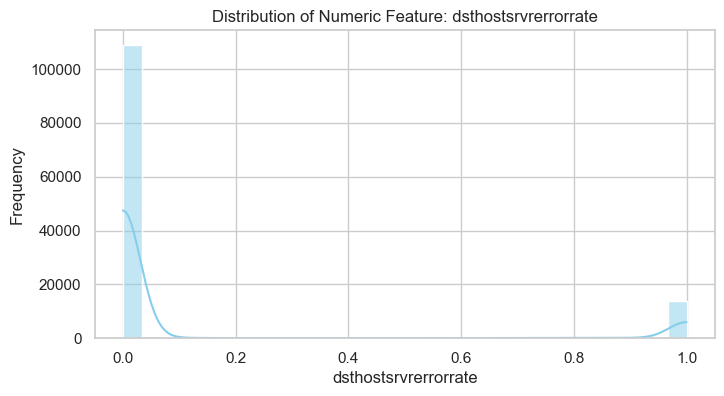

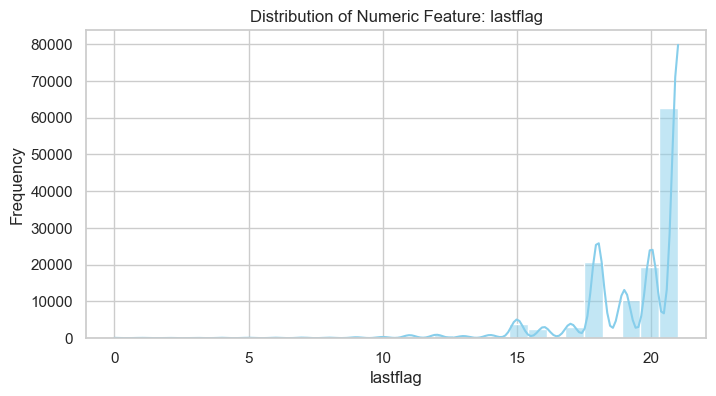

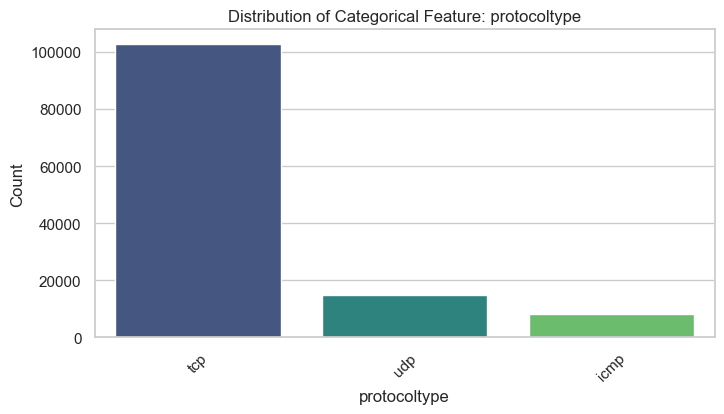

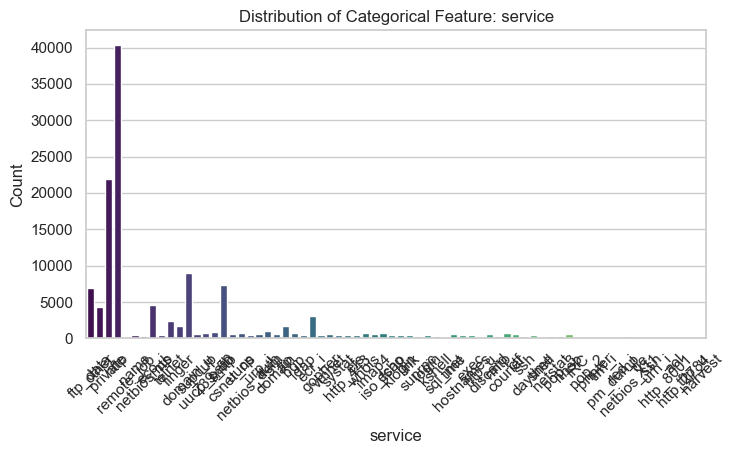

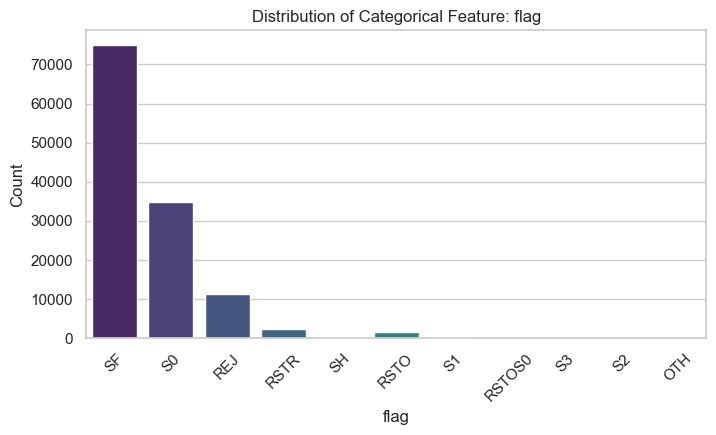

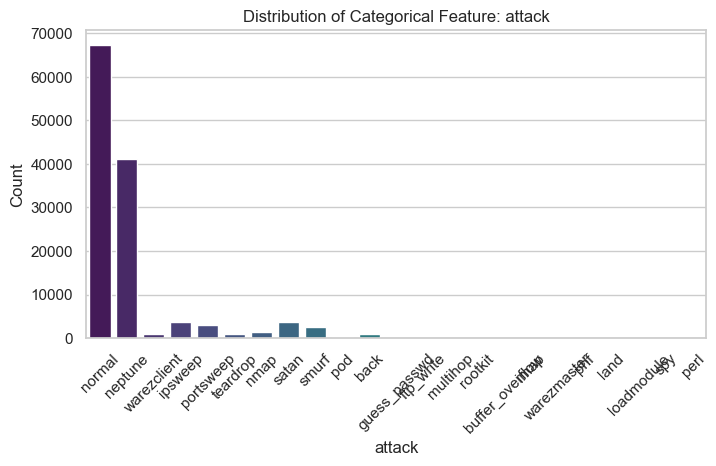

In [9]:
# Call the function to visualize all feature distributions
plot_distributions(df)

# Corelation
To identify highly correlated features in your dataset and drop the ones that are redundant, we can calculate the correlation matrix and use a threshold to decide which features to drop.

In [10]:
def correlation_analysis(data):
    # Compute the correlation matrix
    # Identify numerical columns to scale/normalize
    numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    corr_matrix = data[numerical_columns].corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt='.2f', linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

    # Return the correlation matrix for further analysis
    return corr_matrix

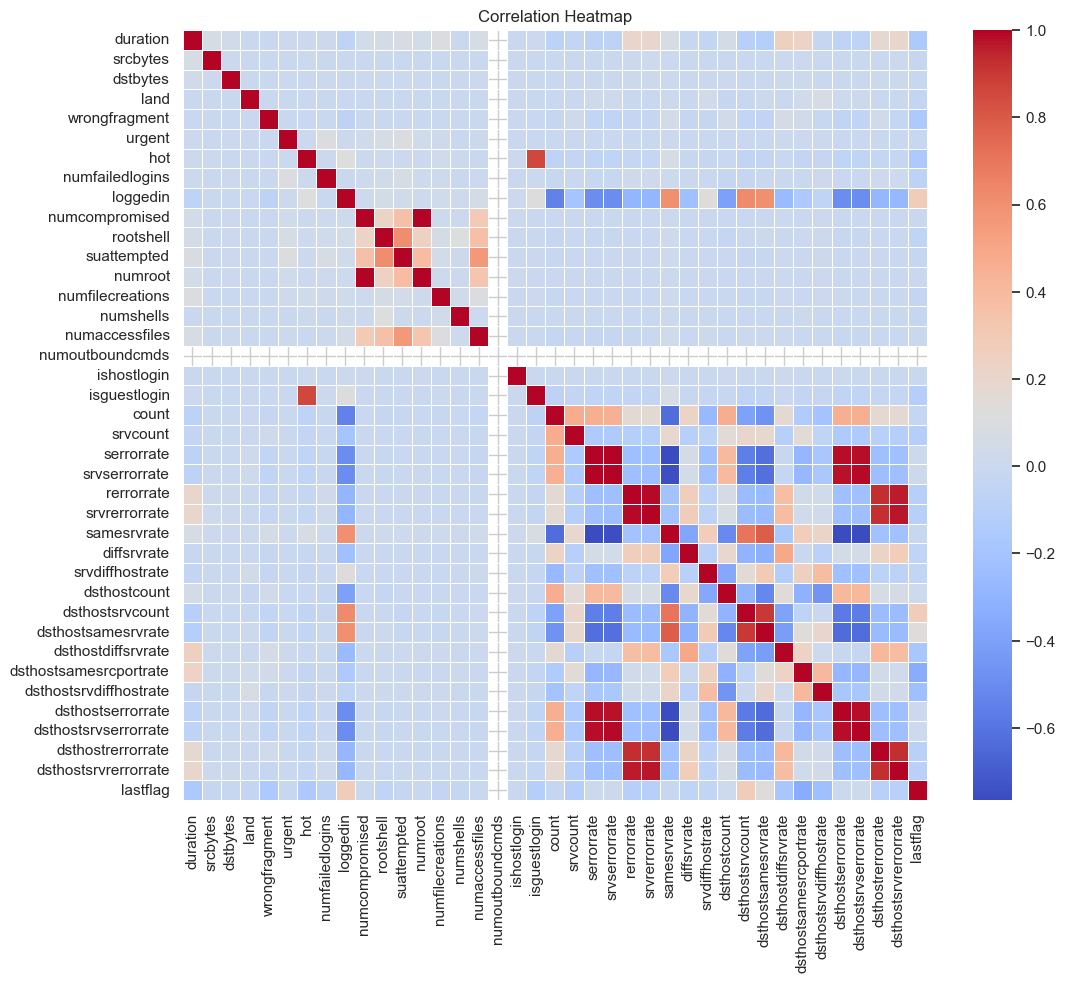

In [11]:
# Call the function for correlation analysis
correlation_matrix = correlation_analysis(df)

In [12]:
# Check for duplicates
print(f"Number of duplicates before removal: {df.duplicated().sum()}")

# Remove duplicates
df_cleaned = df.drop_duplicates()

# Verify if duplicates are removed
print(f"Number of duplicates after removal: {df_cleaned.duplicated().sum()}")


Number of duplicates before removal: 0
Number of duplicates after removal: 0


In [13]:
categorical_columns = ['protocoltype', 'service', 'flag']

# Dictionary to store mappings
label_encoders = {}
label_mappings = {}

# Apply Label Encoding and store mappings
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    label_mappings[col] = {index: label for index, label in enumerate(le.classes_)}

# Print the mappings for each column
for col, mapping in label_mappings.items():
    print(f"Mapping for {col}:")
    for encoded, original in mapping.items():
        print(f"  {encoded} -> {original}")
    print()

# Display the first few rows of the dataset
print("\nEncoded Dataset:")
print(df.head())

Mapping for protocoltype:
  0 -> icmp
  1 -> tcp
  2 -> udp

Mapping for service:
  0 -> IRC
  1 -> X11
  2 -> Z39_50
  3 -> aol
  4 -> auth
  5 -> bgp
  6 -> courier
  7 -> csnet_ns
  8 -> ctf
  9 -> daytime
  10 -> discard
  11 -> domain
  12 -> domain_u
  13 -> echo
  14 -> eco_i
  15 -> ecr_i
  16 -> efs
  17 -> exec
  18 -> finger
  19 -> ftp
  20 -> ftp_data
  21 -> gopher
  22 -> harvest
  23 -> hostnames
  24 -> http
  25 -> http_2784
  26 -> http_443
  27 -> http_8001
  28 -> imap4
  29 -> iso_tsap
  30 -> klogin
  31 -> kshell
  32 -> ldap
  33 -> link
  34 -> login
  35 -> mtp
  36 -> name
  37 -> netbios_dgm
  38 -> netbios_ns
  39 -> netbios_ssn
  40 -> netstat
  41 -> nnsp
  42 -> nntp
  43 -> ntp_u
  44 -> other
  45 -> pm_dump
  46 -> pop_2
  47 -> pop_3
  48 -> printer
  49 -> private
  50 -> red_i
  51 -> remote_job
  52 -> rje
  53 -> shell
  54 -> smtp
  55 -> sql_net
  56 -> ssh
  57 -> sunrpc
  58 -> supdup
  59 -> systat
  60 -> telnet
  61 -> tftp_u
  62 -> tim_

### Explanation:
Correlation Matrix:
df.corr() computes the pairwise correlation of columns in the dataset. It only applies to numerical columns.

** Threshold:
A threshold (e.g., 0.9) is used to identify features that are highly correlated. You can adjust this value based on your needs.

** Iterative Check:
For each pair of features, if the correlation exceeds the threshold, one of the features is added to the correlated_features set.

** Feature Dropping:
The features in correlated_features are dropped from the dataset.

** Output:
The code prints the names of the dropped features and saves the updated dataset to a new file.

In [14]:
# Identify numerical columns to scale/normalize
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Standardization: Mean = 0, Std Dev = 1
standard_scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[numerical_columns] = standard_scaler.fit_transform(df[numerical_columns])

# Normalization: Scale to range [0, 1]
minmax_scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[numerical_columns] = minmax_scaler.fit_transform(df[numerical_columns])

# Display the transformed datasets
print("Standardized Dataset (first 5 rows):")
print(df_standardized.head())

print("\nNormalized Dataset (first 5 rows):")
print(df_normalized.head())

Standardized Dataset (first 5 rows):
   duration  protocoltype   service      flag  srcbytes  dstbytes      land  \
0 -0.110249     -0.124706 -0.686785  0.751111 -0.007679 -0.004919 -0.014089   
1 -0.110249      2.219312  0.781428  0.751111 -0.007737 -0.004919 -0.014089   
2 -0.110249     -0.124706  1.087305 -0.736235 -0.007762 -0.004919 -0.014089   
3 -0.110249     -0.124706 -0.442083  0.751111 -0.007723 -0.002891 -0.014089   
4 -0.110249     -0.124706 -0.442083  0.751111 -0.007728 -0.004814 -0.014089   

   wrongfragment    urgent       hot  ...  dsthostsamesrvrate  \
0      -0.089486 -0.007736 -0.095076  ...           -0.782367   
1      -0.089486 -0.007736 -0.095076  ...           -1.161030   
2      -0.089486 -0.007736 -0.095076  ...           -0.938287   
3      -0.089486 -0.007736 -0.095076  ...            1.066401   
4      -0.089486 -0.007736 -0.095076  ...            1.066401   

   dsthostdiffsrvrate  dsthostsamesrcportrate  dsthostsrvdiffhostrate  \
0           -0.280282   

## Explanation of Changes:

Dropping Only One Feature from Each Pair:

For each correlated pair, only the first feature (i.e., pair[0]) is added to the correlated_features set, ensuring that only one feature from each correlated pair is dropped.

Set Data Structure for Features to Drop:

A set is used to ensure that each feature is only added once, even if it appears in multiple correlated pairs.

In [15]:
# Select only numeric fields
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Set a threshold for correlation (e.g., 0.9)
threshold = 0.9

# Initialize a list to store correlated column pairs
correlated_pairs = []

# Find highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:  # Check if correlation is above the threshold
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            correlated_pairs.append((colname1, colname2))

# Print correlated column pairs
if correlated_pairs:
    print("Highly correlated column pairs (correlation > 0.9):")
    for pair in correlated_pairs:
        print(f"{pair[0]} and {pair[1]}")
else:
    print("No highly correlated column pairs found.")

# Initialize a set to keep track of features to drop
correlated_features = set()

# Keep only the first feature of each correlated pair (drop the second one)
for pair in correlated_pairs:
    correlated_features.add(pair[0])  # Add only the first feature to the drop list

# Drop the selected features from the original dataframe
df = df.drop(columns=correlated_features)

# Output the dropped features
print(f"\nDropped features due to high correlation: {correlated_features}")


Highly correlated column pairs (correlation > 0.9):
numroot and numcompromised
srvserrorrate and serrorrate
srvrerrorrate and rerrorrate
dsthostserrorrate and serrorrate
dsthostserrorrate and srvserrorrate
dsthostsrvserrorrate and serrorrate
dsthostsrvserrorrate and srvserrorrate
dsthostsrvserrorrate and dsthostserrorrate
dsthostrerrorrate and rerrorrate
dsthostrerrorrate and srvrerrorrate
dsthostsrvrerrorrate and rerrorrate
dsthostsrvrerrorrate and srvrerrorrate
dsthostsrvrerrorrate and dsthostrerrorrate

Dropped features due to high correlation: {'numroot', 'dsthostserrorrate', 'dsthostrerrorrate', 'srvrerrorrate', 'dsthostsrvserrorrate', 'dsthostsrvrerrorrate', 'srvserrorrate'}


In [16]:
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,attack,lastflag
0,0,1,20,9,491,0,0,0,0,0,...,0.00,0.00,150,25,0.17,0.03,0.17,0.00,normal,20
1,0,2,44,9,146,0,0,0,0,0,...,0.15,0.00,255,1,0.00,0.60,0.88,0.00,normal,15
2,0,1,49,5,0,0,0,0,0,0,...,0.07,0.00,255,26,0.10,0.05,0.00,0.00,neptune,19
3,0,1,24,9,232,8153,0,0,0,0,...,0.00,0.00,30,255,1.00,0.00,0.03,0.04,normal,21
4,0,1,24,9,199,420,0,0,0,0,...,0.00,0.09,255,255,1.00,0.00,0.00,0.00,normal,21


# Feature Engineering Steps

Interaction Features: Combine numerical features to create interaction terms.

Aggregated Features: Create summary statistics like the mean, sum, or count of certain groups of features.

Polynomial Features: Introduce non-linear relationships between features by applying polynomial transformation.



In [17]:
# Creating Interaction Features (combining numerical features)
df['src_dst_bytes_interaction'] = df['srcbytes'] * df['dstbytes']  # Interaction between source and destination bytes
df['num_failed_logins_hot_interaction'] = df['numfailedlogins'] * df['hot']  # Interaction between failed logins and 'hot' indicator
df['num_compromised_su_interaction'] = df['numcompromised'] * df['suattempted']  # Interaction between compromised and su attempt

# Aggregated Features: Summary statistics over groups of features
df['total_data_transfer'] = df['srcbytes'] + df['dstbytes']  # Total data transferred
df['total_access_operations'] = df['numfilecreations'] + df['numshells'] + df['numaccessfiles']  # Total access-related operations



# Drop any features that you may not need
df = df.drop(columns=['srcbytes', 'dstbytes', 'attack'])  # Dropping original srcbytes and dstbytes if needed


In [18]:
df.head()

,duration,protocoltype,service,flag,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,lastflag,src_dst_bytes_interaction,num_failed_logins_hot_interaction,num_compromised_su_interaction,total_data_transfer,total_access_operations
0,0,1,20,9,0,0,0,0,0,0,...,0.17,0.03,0.17,0.00,20,0,0,0,491,0
1,0,2,44,9,0,0,0,0,0,0,...,0.00,0.60,0.88,0.00,15,0,0,0,146,0
2,0,1,49,5,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,19,0,0,0,0,0
3,0,1,24,9,0,0,0,0,0,1,...,1.00,0.00,0.03,0.04,21,1891496,0,0,8385,0
4,0,1,24,9,0,0,0,0,0,1,...,1.00,0.00,0.00,0.00,21,83580,0,0,619,0


# Key Feature Engineering Techniques Applied:

Interaction Features:

src_dst_bytes_interaction: Multiplying source and destination bytes.

num_failed_logins_hot_interaction: Multiplying failed login attempts and the 'hot' indicator.

num_compromised_su_interaction: Multiplying the number of compromised conditions and su attempts.

Aggregated Features:

total_data_transfer: Sum of srcbytes and dstbytes.

total_access_operations: Sum of file creations, shells, and access file operations.

Polynomial Features: Polynomial transformations (degree 2) were applied to all numeric features to introduce 
interaction terms and squared terms, which can help capture more complex relationships between features.

Outcome:
New interaction features are added, potentially revealing hidden patterns between features.
Polynomial features are added, enriching the dataset with higher-order terms.
The final dataset is saved as Network_anomaly_data_feature_engineered_with_interactions.csv.

In [19]:
# Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Use Cross-Validation
For supervised tasks, perform cross-validation with PCA and evaluate model accuracy for different variance thresholds.

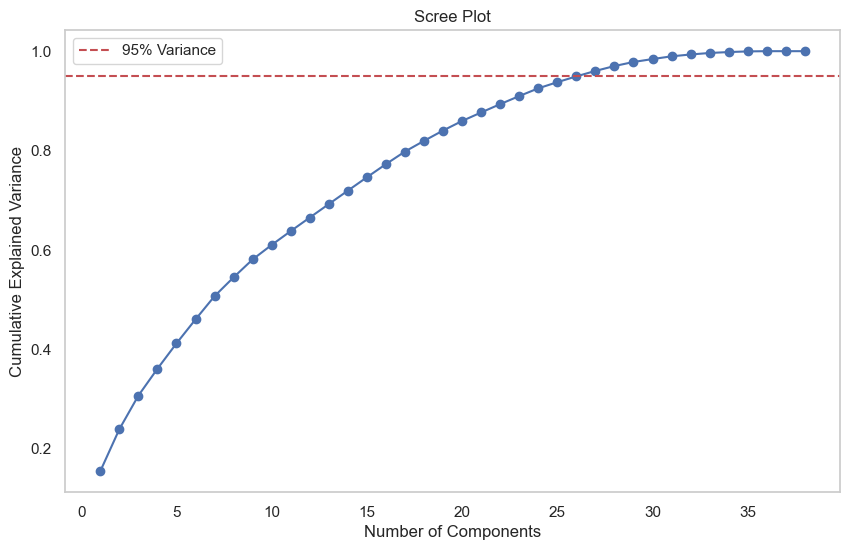

In [20]:
# Perform PCA without setting n_components
pca = PCA()
pca.fit(scaled_data)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance")
plt.title("Scree Plot")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid()
plt.show()


In [21]:
# Define variance thresholds to test
variance_thresholds = [0.90, 0.92, 0.95, 0.98, 0.99]
results = {}

for threshold in variance_thresholds:
    pca = PCA(n_components=threshold)
    reduced_data = pca.fit_transform(scaled_data)
    
    # Example: Evaluate clustering performance
    kmeans = KMeans(n_clusters=8, random_state=42)
    kmeans_labels = kmeans.fit_predict(reduced_data)
    silhouette_avg = silhouette_score(reduced_data, kmeans_labels)
    
    results[threshold] = silhouette_avg
    print(f"Variance Retained: {threshold}, Silhouette Score: {silhouette_avg}")

# Find the best threshold
optimal_threshold = max(results, key=results.get)
print(f"Optimal Variance Threshold: {optimal_threshold}")

Variance Retained: 0.9, Silhouette Score: 0.43484026271952736
Variance Retained: 0.92, Silhouette Score: 0.43089981535590943
Variance Retained: 0.95, Silhouette Score: 0.41338015898269453
Variance Retained: 0.98, Silhouette Score: 0.348138936087572
Variance Retained: 0.99, Silhouette Score: 0.39400356314402013
Optimal Variance Threshold: 0.9


## Evaluate Dimensionality Reduction Trade-Off

If you aim to reduce computation time, consider using a lower threshold (e.g., 90%) while still ensuring the model performs adequately. Conversely, if interpretability or high fidelity is important, aim for higher thresholds (e.g., 99%).

In [22]:
# Dimensionality Reduction (PCA)
pca = PCA(n_components=0.9)  # Retain 95% variance
reduced_data = pca.fit_transform(scaled_data)
print(f"Reduced data shape: {reduced_data.shape}")

Reduced data shape: (125973, 23)


## Tune t-SNE Hyperparameters

t-SNE is sensitive to its hyperparameters:

Perplexity: Default is 30. Try values like 5, 10, 50, or 100.

Learning Rate: Default is 200. Experiment with smaller or larger values.

n_iter: Increase from the default (1000) to 3000 or higher for better convergence.

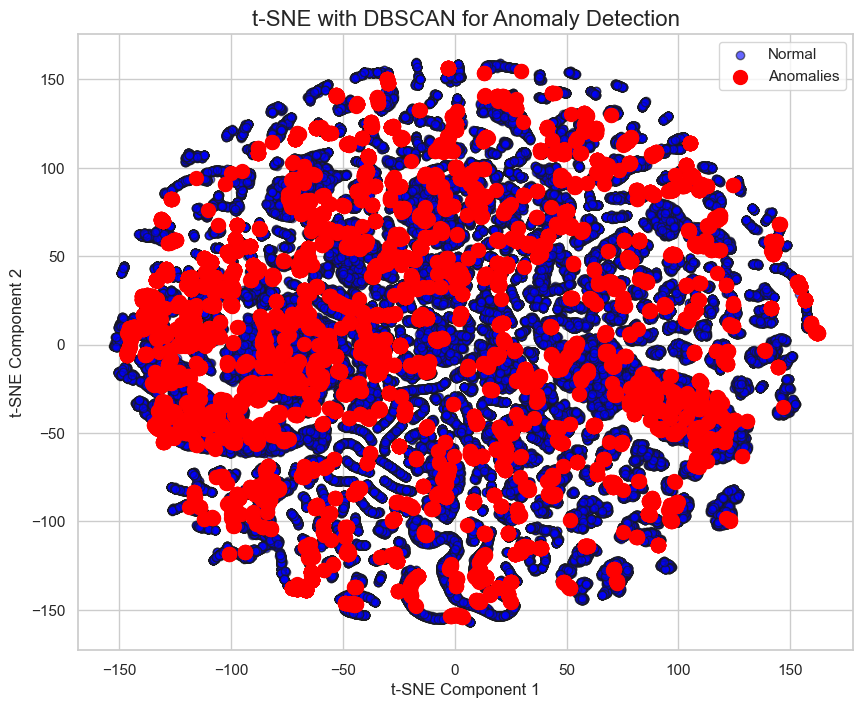

Number of anomalies detected: 12071


In [23]:
# t-SNE with adjusted parameters
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200, n_iter=3000, random_state=42)
features_tsne = tsne.fit_transform(reduced_data)

# Apply DBSCAN for anomaly detection
dbscan = DBSCAN(eps=2, min_samples=50)
labels = dbscan.fit_predict(features_tsne)

# Identify anomalies (label -1)
anomalies = labels == -1

# Plot results
plt.figure(figsize=(10, 8))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c='blue', label='Normal', alpha=0.6, edgecolors='k')
plt.scatter(features_tsne[anomalies, 0], features_tsne[anomalies, 1], c='red', label='Anomalies', s=100)
plt.title('t-SNE with DBSCAN for Anomaly Detection', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

print(f"Number of anomalies detected: {np.sum(anomalies)}")


Silhouette Score for k=2: 0.3439016240333557
Silhouette Score for k=3: 0.3592343438139159
Silhouette Score for k=4: 0.33236575429699333
Silhouette Score for k=5: 0.3738338099419492
Silhouette Score for k=6: 0.4153354086261927
Silhouette Score for k=7: 0.4126017355054023
Silhouette Score for k=8: 0.43484026271952736
Silhouette Score for k=9: 0.4351640602291579
Silhouette Score for k=10: 0.45703504150783913
Optimal number of clusters (k): 10 with Silhouette Score: 0.45703504150783913


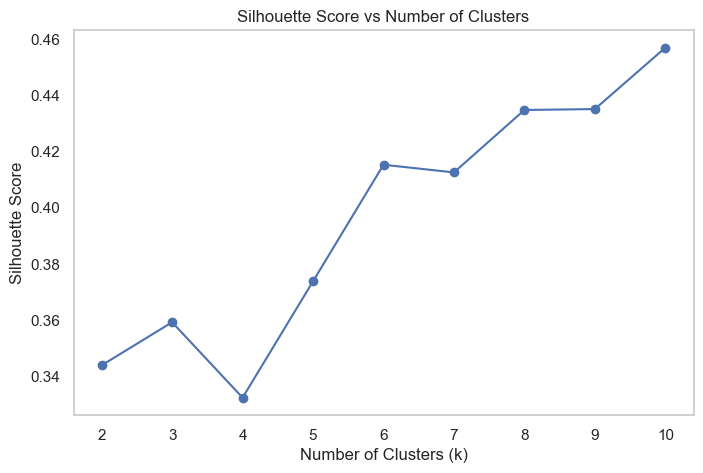

In [24]:
# Determine optimal number of clusters (k) using Silhouette Score
silhouette_scores = {}
k_range = range(2, 11)  # Explore k values from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced_data)
    score = silhouette_score(reduced_data, labels)
    silhouette_scores[k] = score
    print(f"Silhouette Score for k={k}: {score}")

# Find the k with the maximum Silhouette Score
optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"Optimal number of clusters (k): {optimal_k} with Silhouette Score: {silhouette_scores[optimal_k]}")

# Visualize the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o', color='b')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()


In [25]:
# Clustering - KMeans
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_data)
silhouette_avg = silhouette_score(reduced_data, kmeans_labels)
print(f"Silhouette Score for KMeans: {silhouette_avg}")

Silhouette Score for KMeans: 0.43484026271952736


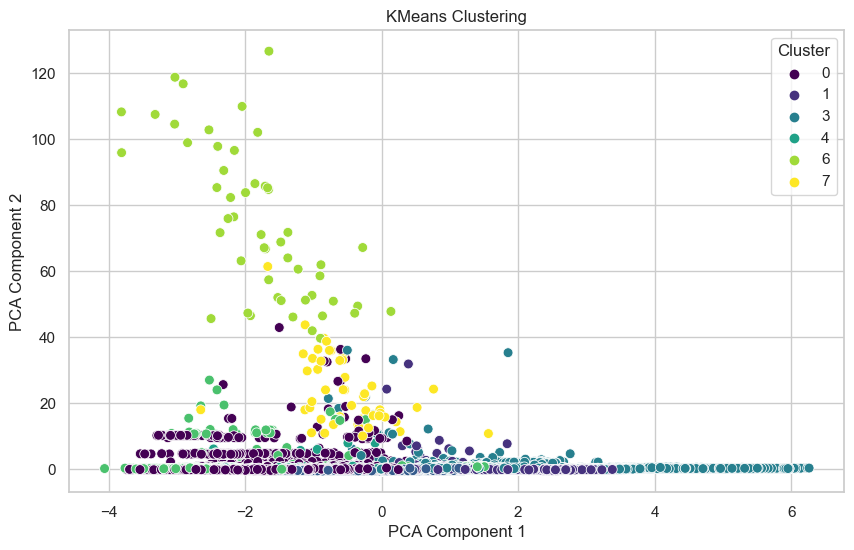

In [26]:
# Plot Clusters for KMeans
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=kmeans_labels, palette='viridis', s=50)
plt.title("KMeans Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


### Step 1: K-Distance Plot


Plots the distances to the k-th nearest neighbor.
Look for the "elbow point" (where the plot bends). Use this as a candidate for eps.

### Step 2: Parameter Sweep


Iterate over multiple eps and min_samples combinations.

Compute the number of clusters, noise points, and silhouette score for each combination.

A good choice has:

A high silhouette score.

A balance between a reasonable number of clusters and noise points.

In [27]:
# Step 1: K-Distance Plot
def plot_k_distance(data, k=5):
    """
    Plots the k-distance graph for optimizing DBSCAN's eps parameter.
    :param data: Input data for DBSCAN (e.g., PCA-reduced data).
    :param k: Number of neighbors to consider for the k-distance.
    """
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    k_distances = np.sort(distances[:, k - 1])  # Sort the k-th nearest distances

    plt.figure(figsize=(10, 6))
    plt.plot(k_distances, marker="o")
    plt.title(f"K-Distance Graph (k={k})")
    plt.xlabel("Sample Index")
    plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
    plt.grid()
    plt.show()


In [28]:
# Step 2: DBSCAN Optimization and Evaluation
def optimize_dbscan(data, eps_values, min_samples_values):
    """
    Optimizes DBSCAN parameters and evaluates clusters.
    :param data: Input data for DBSCAN (e.g., PCA-reduced data).
    :param eps_values: List of eps values to evaluate.
    :param min_samples_values: List of min_samples values to evaluate.
    """
    best_params = None
    best_score = -1

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            if n_clusters > 1:
                silhouette_avg = silhouette_score(data, labels)
            else:
                silhouette_avg = -1

            print(f"eps={eps}, min_samples={min_samples}, Clusters={n_clusters}, Noise={n_noise}, Silhouette={silhouette_avg:.3f}")

            # Keep track of the best parameters
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_params = (eps, min_samples)

    print(f"Best Parameters: eps={best_params[0]}, min_samples={best_params[1]}, Silhouette={best_score:.3f}")
    return best_params

In [29]:
# Step 3: Visualizing DBSCAN Results
def plot_dbscan_results(data, labels):
    """
    Plots DBSCAN results, highlighting noise, edge points, and core points.
    :param data: PCA-reduced 2D data.
    :param labels: DBSCAN labels.
    """
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    unique_labels = set(labels)
    
    colors = sns.color_palette("husl", len(unique_labels))  # Generate unique colors
    plt.figure(figsize=(10, 6))

    for label, color in zip(unique_labels, colors):
        if label == -1:
            # Noise points
            plt.scatter(data[labels == label, 0], data[labels == label, 1], c="red", s=50, label="Noise")
        else:
            # Core and edge points
            plt.scatter(data[labels == label, 0], data[labels == label, 1], color=color, s=50, label=f"Cluster {label}")

    plt.title("DBSCAN Clustering Results")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid()
    plt.show()

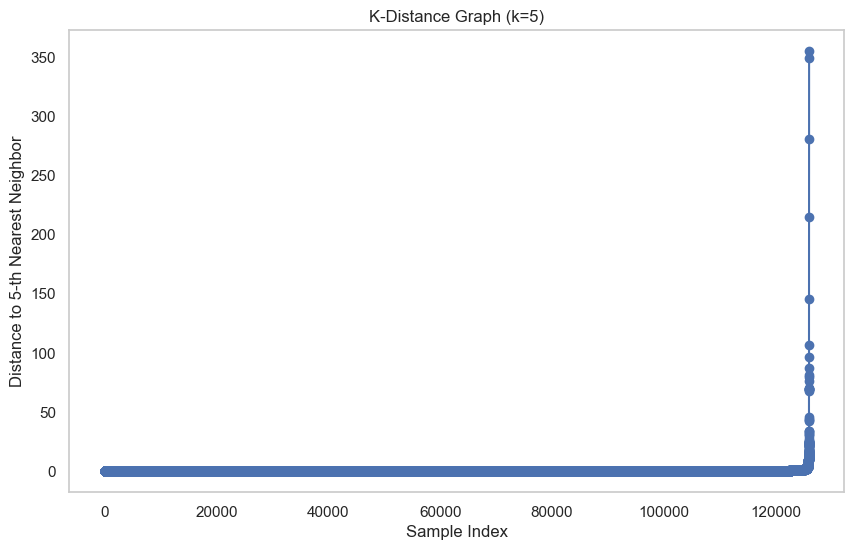

In [30]:
# Step 4: Execute DBSCAN Optimization and Plotting
# Replace `reduced_data` with your PCA-reduced dataset.
plot_k_distance(reduced_data, k=5)  # Plot k-distance graph

eps=0.3, min_samples=5, Clusters=812, Noise=7876, Silhouette=-0.247
eps=0.3, min_samples=10, Clusters=448, Noise=11690, Silhouette=-0.233
eps=0.3, min_samples=25, Clusters=206, Noise=18796, Silhouette=-0.065
eps=0.3, min_samples=50, Clusters=114, Noise=26907, Silhouette=-0.209
eps=0.5, min_samples=5, Clusters=344, Noise=3559, Silhouette=0.057
eps=0.5, min_samples=10, Clusters=210, Noise=5380, Silhouette=0.182
eps=0.5, min_samples=25, Clusters=117, Noise=8969, Silhouette=0.269
eps=0.5, min_samples=50, Clusters=71, Noise=13634, Silhouette=0.259
eps=1, min_samples=5, Clusters=131, Noise=1369, Silhouette=-0.073
eps=1, min_samples=10, Clusters=83, Noise=1970, Silhouette=-0.035
eps=1, min_samples=25, Clusters=58, Noise=3099, Silhouette=-0.019
eps=1, min_samples=50, Clusters=42, Noise=4872, Silhouette=-0.015
Best Parameters: eps=0.5, min_samples=25, Silhouette=0.269


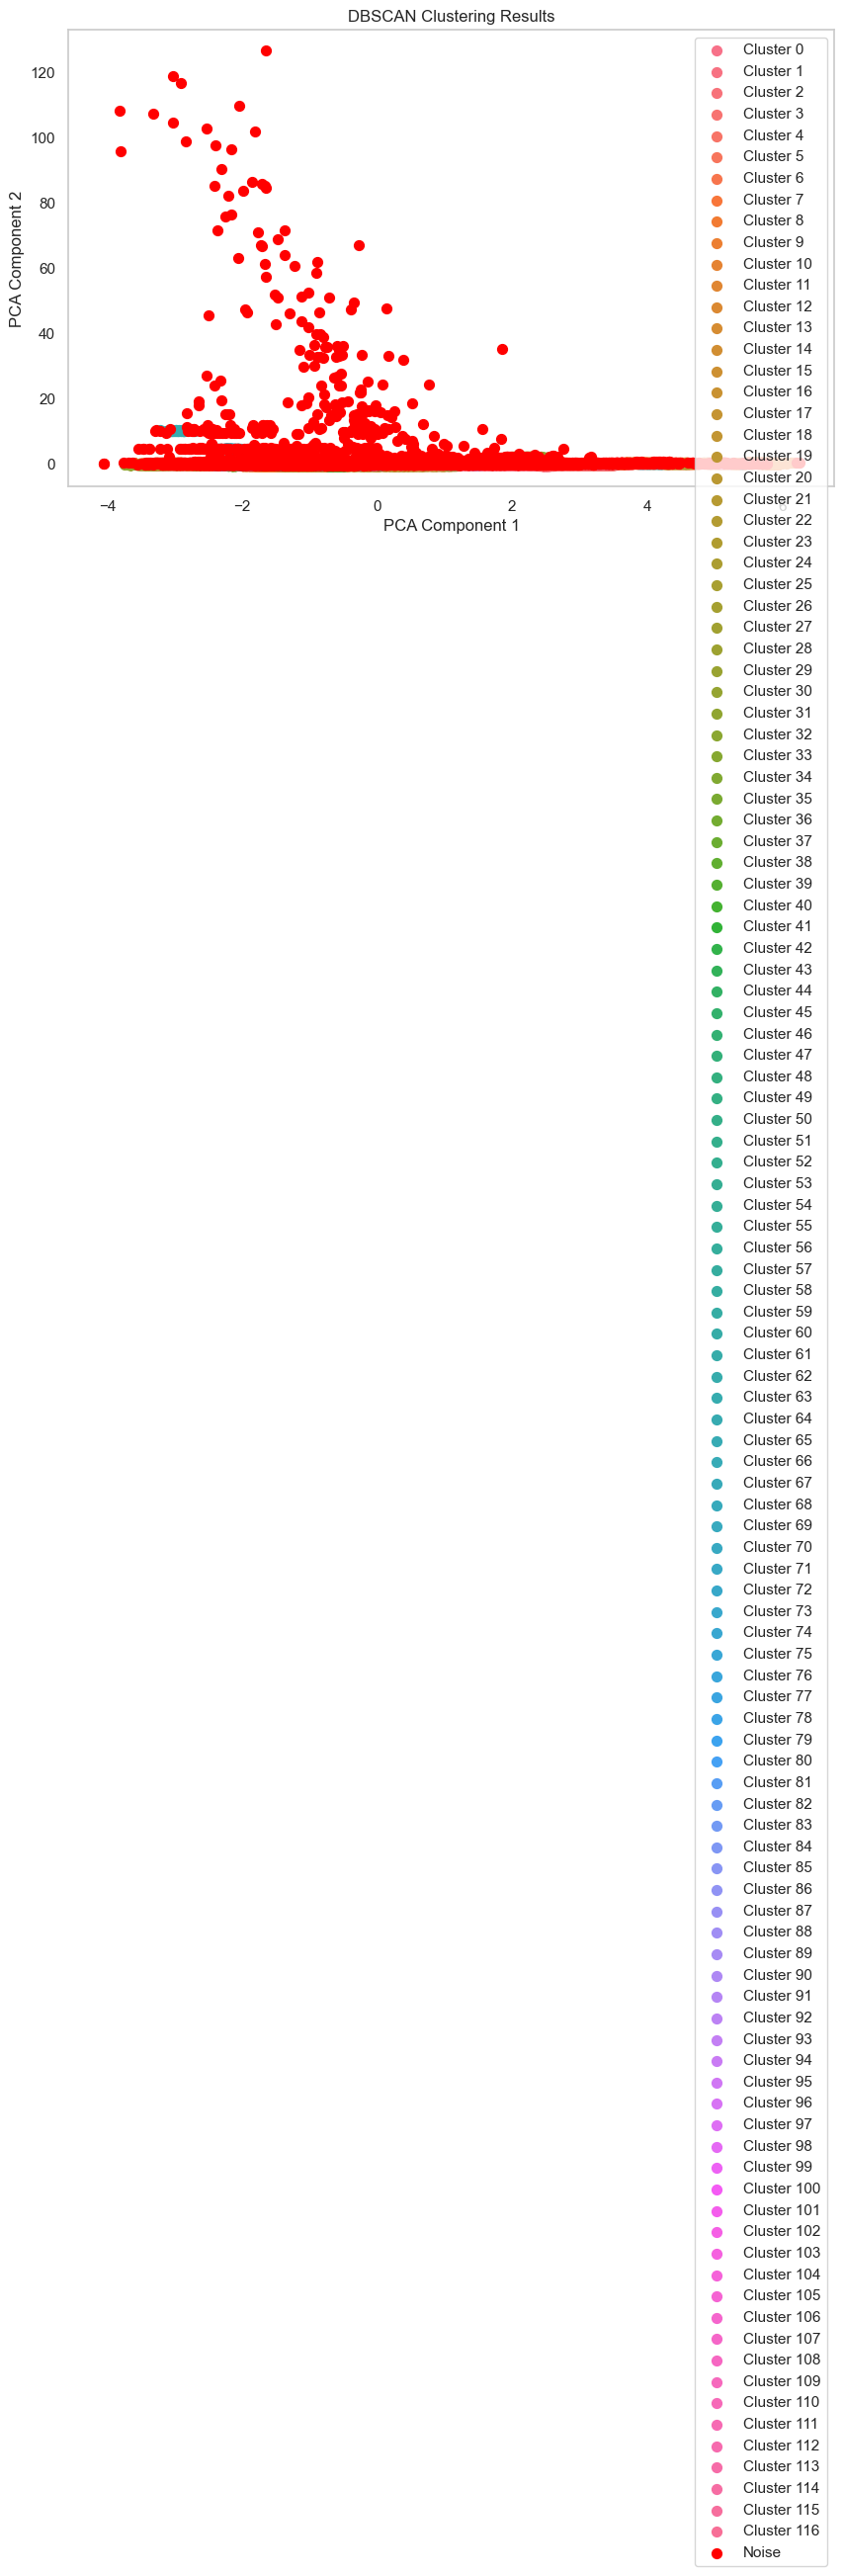

In [31]:
# Optimize DBSCAN parameters
eps_values = [0.3, 0.5, 1]
min_samples_values = [5, 10, 25, 50]
best_eps, best_min_samples = optimize_dbscan(reduced_data, eps_values, min_samples_values)

# Apply DBSCAN with the best parameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(reduced_data)

# Plot DBSCAN results
plot_dbscan_results(reduced_data, dbscan_labels)

## K-Distance Plot: 
Visualize the distances to the k-th nearest neighbor to choose a suitable eps.

## Parameter Optimization: 
Loop through eps and min_samples values, compute silhouette scores, and find the optimal combination.
Plot Clustering Results: Visualize clusters, noise, and other points.

## Output

K-Distance Graph: Helps identify the "elbow point" for eps.

Parameter Results: Lists clusters, noise, and silhouette scores for each parameter combination.

Cluster Visualization: Distinguishes noise (red) and clusters (unique colors).

In [32]:
# Visualize Results (PCA-reduced 2D data)
tsne = PCA(n_components=.9)
data_2d = tsne.fit_transform(reduced_data)

In [33]:
# DBSCAN
dbscan = DBSCAN(eps=1, min_samples=50)
dbscan_labels = dbscan.fit_predict(reduced_data)
print(f"Number of clusters (DBSCAN): {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Number of anomalies detected: {(dbscan_labels == -1).sum()}")

Number of clusters (DBSCAN): 42
Number of anomalies detected: 4872


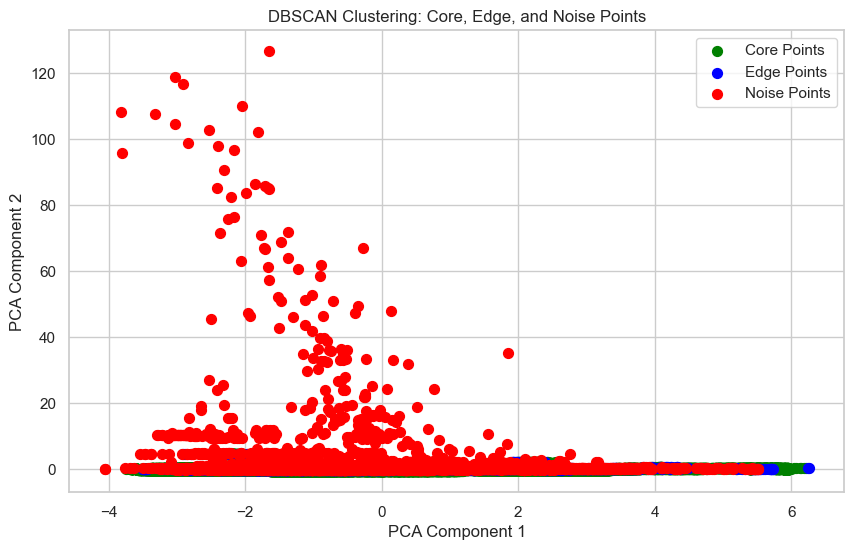

In [34]:
# Identify core points using DBSCAN's attributes
core_samples_mask = np.zeros_like(dbscan_labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Create arrays for different categories
core_points = (core_samples_mask & (dbscan_labels != -1))
edge_points = (~core_samples_mask & (dbscan_labels != -1))
noise_points = (dbscan_labels == -1)

# Plot points with separate colors for noise, edge, and core points
plt.figure(figsize=(10, 6))

# Plot core points
plt.scatter(
    data_2d[core_points, 0],
    data_2d[core_points, 1],
    s=50, c="green", label="Core Points"
)

# Plot edge points
plt.scatter(
    data_2d[edge_points, 0],
    data_2d[edge_points, 1],
    s=50, c="blue", label="Edge Points"
)

# Plot noise points
plt.scatter(
    data_2d[noise_points, 0],
    data_2d[noise_points, 1],
    s=50, c="red", label="Noise Points"
)

# Add title, labels, and legend
plt.title("DBSCAN Clustering: Core, Edge, and Noise Points")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [35]:
# Anomaly Detection - Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels_iso = iso_forest.fit_predict(scaled_data)
print(f"Number of clusters (Isolation Forest): {len(set(anomaly_labels_iso)) - (1 if -1 in anomaly_labels_iso else 0)}")
print(f"Number of anomalies detected: {(anomaly_labels_iso == -1).sum()}")

Number of clusters (Isolation Forest): 1
Number of anomalies detected: 6298


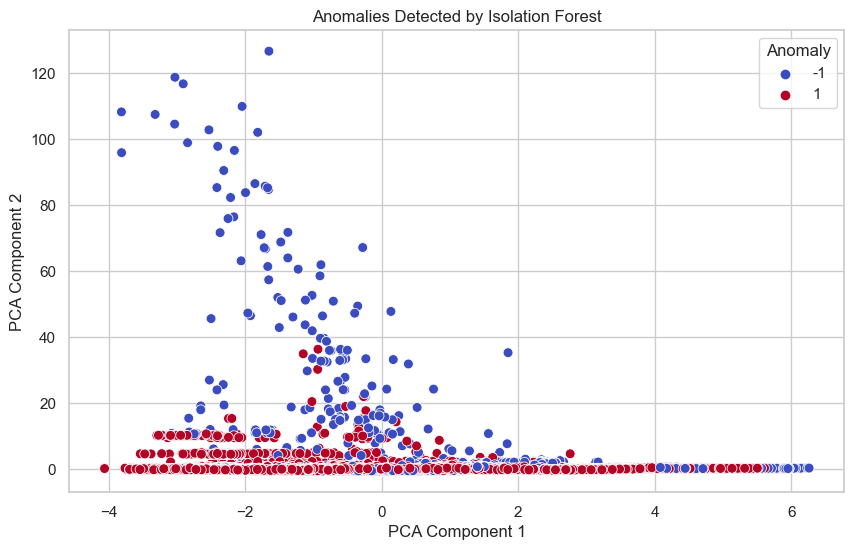

In [36]:
# Plot Anomalies Detected by Isolation Forest
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=anomaly_labels_iso, palette='coolwarm', s=50)
plt.title("Anomalies Detected by Isolation Forest")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Anomaly")
plt.show()

In [37]:
# Anomaly Detection - Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
anomaly_labels_lof = lof.fit_predict(scaled_data)
print(f"Number of clusters (LOF): {len(set(anomaly_labels_lof)) - (1 if -1 in anomaly_labels_lof else 0)}")
print(f"Number of anomalies detected: {(anomaly_labels_lof == -1).sum()}")

Number of clusters (LOF): 1
Number of anomalies detected: 6299


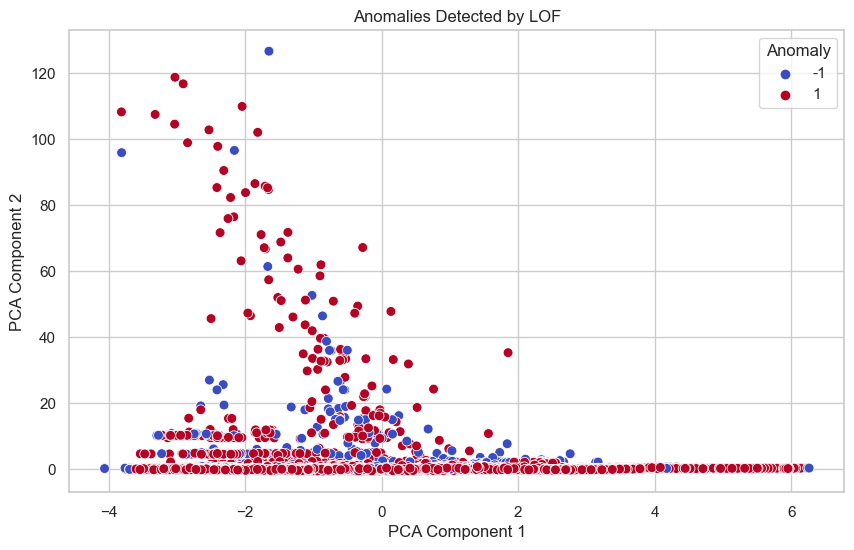

In [38]:
# Plot Anomalies Detected by LOF
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=anomaly_labels_lof, palette='coolwarm', s=50)
plt.title("Anomalies Detected by LOF")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Anomaly")
plt.show()

In [39]:
# Save the model to a file
joblib.dump(iso_forest, "isolation_forest_model.joblib")
print("Model saved successfully.")

Model saved successfully.
